In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [2]:
using Revise 
using ReactiveMP, GraphPPL, RxInfer, Distributions, LinearAlgebra,Plots, Random
using BenchmarkTools
pgfplotsx()
import KernelFunctions: Matern52Kernel, with_lengthscale

┌ Warning: Package ReactiveMP does not have KernelFunctions in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added KernelFunctions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading KernelFunctions into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


## Test with fixed hyperparameters

In [3]:
Random.seed!(3)
xmin, xmax = -3, 3  # Bounds of the data
N = 200# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func(θ) =  with_lengthscale(Matern52Kernel(),θ) 
meanfunc   = (x) -> 0.0;
θ_init = 1.0 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(SoR(50))

CovarianceMatrixStrategy{DeterministicInducingConditional}(DeterministicInducingConditional(50, MersenneTwister(1), nothing, nothing, nothing, nothing))

In [4]:
# test new thing
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train,strategy)
    ### change here 
    x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

In [5]:
@constraints function gpconstraints()   
    q(x,γ) = q(x)q(γ)
end

gpconstraints (generic function with 1 method)

In [6]:
nits = 10
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init,cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    # free_energy = true,
    showprogress = true
)

Progress:  20%|█████████                                |  ETA: 0:00:32

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Inference results:
  Posteriors       | available for (γ, x)


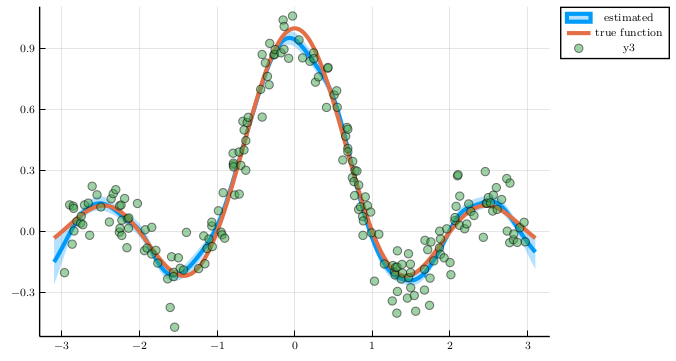

In [7]:
#SoR
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

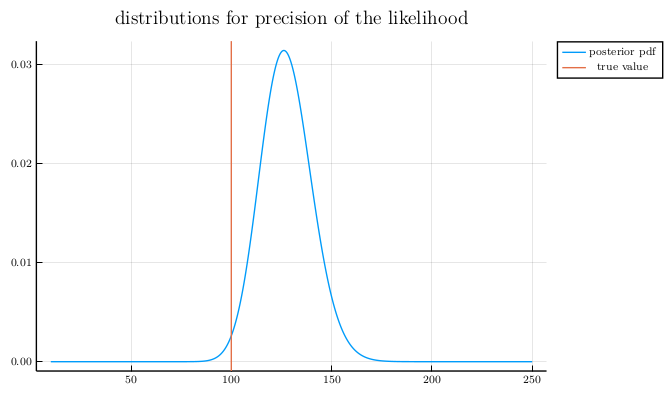

In [8]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)

In [9]:
#After improvement
@benchmark inference(
    model = gp_regress(length($ytrain), $k_func, $meanfunc, $xtrain,$xtest,$log_θ_init, $cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = $gpconstraints(),
    iterations = $nits,  
    data  = (y = $ytrain,)
)

BenchmarkTools.Trial: 18 samples with 1 evaluation.
 Range (min … max):  241.086 ms … 333.323 ms  ┊ GC (min … max): 7.89% … 7.88%
 Time  (median):     277.008 ms               ┊ GC (median):    8.16%
 Time  (mean ± σ):   280.628 ms ±  23.459 ms  ┊ GC (mean ± σ):  8.72% ± 2.64%

  ▁       ▁▁  ▁ ▁     ▁▁ ██  ▁▁        ▁▁      ▁  ▁           ▁  
  █▁▁▁▁▁▁▁██▁▁█▁█▁▁▁▁▁██▁██▁▁██▁▁▁▁▁▁▁▁██▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  241 ms           Histogram: frequency by time          333 ms <

 Memory estimate: 166.20 MiB, allocs estimate: 251928.